# Análise de Dados em Criptomoedas: Detecção de fraudes

---



**Professora:** Profa. Dra. Isadora Garcia Ferrão

📧 isadoraferrao@usp.br

🌐 [linkedin](https://www.linkedin.com/in/isadora-ferrao/)

🔗 [Instagram](https://www.instagram.com/isadora.ferrao/)

**Descrição dos Dados:** Os dados foram coletados de fontes públicas de monitoramento de carteiras e transações na rede Ethereum, como Etherscan, Dune Analytics e outras plataformas abertas. São dados reais e anonimizados, amplamente utilizados em estudos de detecção de fraude e análise de comportamento no mercado de criptomoedas. Cada linha representa uma carteira e suas métricas de atividade.

**Objetivo:** Construir um modelo preditivo capaz de identificar, com base nas métricas de transações, quando uma carteira apresenta comportamento anômalo, caracterizando uma potencial fraude.



## **Análise exploratória**

In [26]:
!python -m pip install pandas numpy matplotlib seaborn scikit-learn


In [27]:
# Importando bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [28]:
# Configuração básica dos gráficos
plt.style.use('default')

In [29]:
# --- 1. Carregamento e limpeza dos dados ---
df = pd.read_csv('ethereum_transactions.csv.csv')

In [30]:
# Remover espaços em branco dos nomes das colunas
df.columns = df.columns.str.strip()

In [31]:
# Cria a coluna 'is_fraud' de forma direta:
# 1 se 'Sent tnx' for maior que (média + 2 * desvio padrão), senão 0
df["is_fraud"] = (df["Sent tnx"] > (df["Sent tnx"].mean() + 2 * df["Sent tnx"].std())).astype(int)

In [32]:
# Exibir informações iniciais para diagnóstico
print("Colunas do DataFrame", df.columns.tolist())
print(df.head())
print(df.describe())

Colunas do DataFrame ['Unnamed: 0', 'Index', 'Address', 'FLAG', 'Avg min between sent tnx', 'Avg min between received tnx', 'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx', 'Number of Created Contracts', 'Unique Received From Addresses', 'Unique Sent To Addresses', 'min value received', 'max value received', 'avg val received', 'min val sent', 'max val sent', 'avg val sent', 'min value sent to contract', 'max val sent to contract', 'avg value sent to contract', 'total transactions (including tnx to create contract', 'total Ether sent', 'total ether received', 'total ether sent contracts', 'total ether balance', 'Total ERC20 tnxs', 'ERC20 total Ether received', 'ERC20 total ether sent', 'ERC20 total Ether sent contract', 'ERC20 uniq sent addr', 'ERC20 uniq rec addr', 'ERC20 uniq sent addr.1', 'ERC20 uniq rec contract addr', 'ERC20 avg time between sent tnx', 'ERC20 avg time between rec tnx', 'ERC20 avg time between rec 2 tnx', 'ERC20 avg time between contract tnx',

## **Visualizando Correlações e Distribuições**

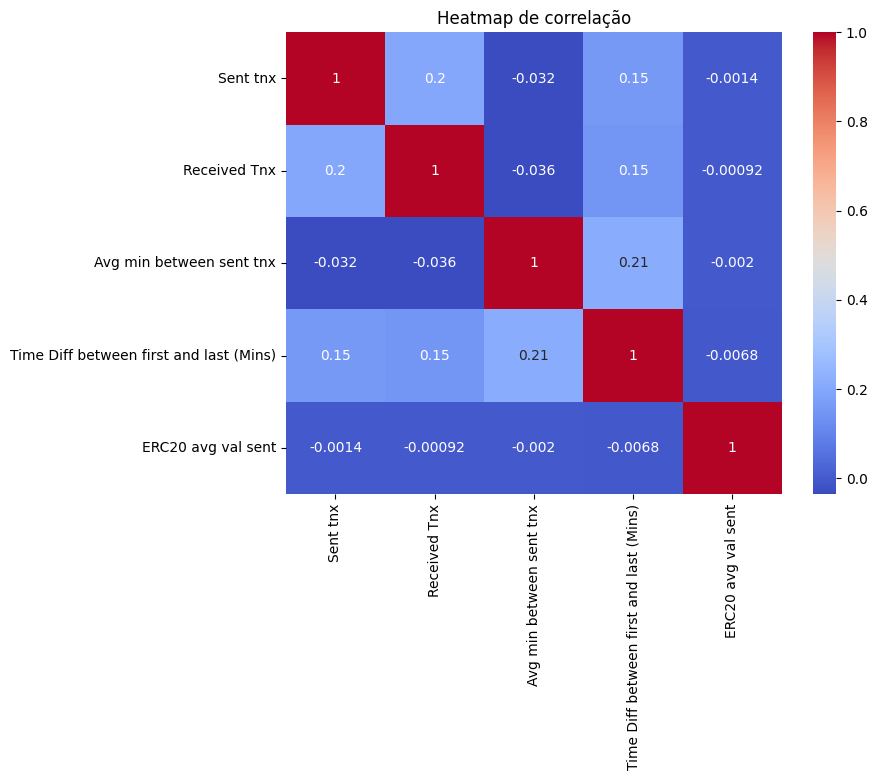

In [33]:
# Defina as colunas relevantes para a correlação
cols_for_corr = [
    "Sent tnx",
    "Received Tnx",
    "Avg min between sent tnx",
    "Time Diff between first and last (Mins)",
    "ERC20 avg val sent"
]

corr_matrix = df[cols_for_corr].corr()

# Plotando o heatmap de correlação
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Heatmap de correlação")
plt.show()

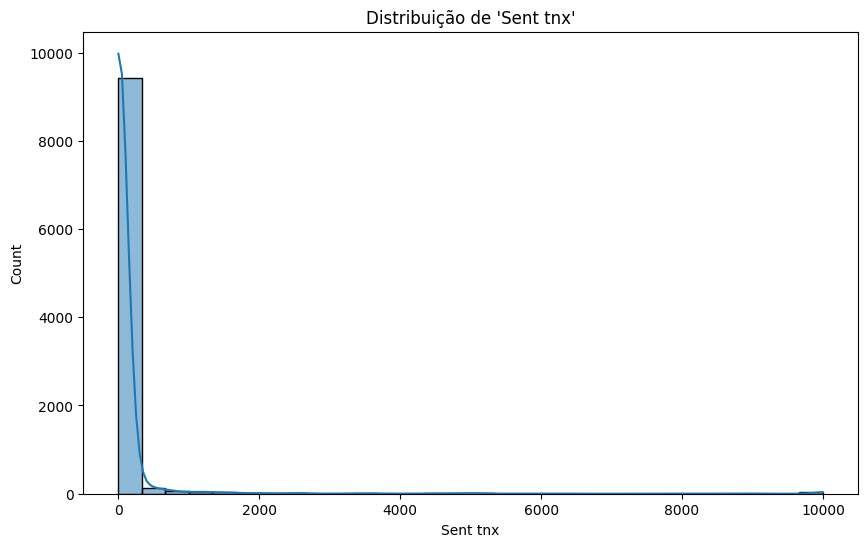

In [34]:
# Histogramas para visualizar a distribuição de 'Sent tnx'
plt.figure(figsize=(10, 6))
sns.histplot(df["Sent tnx"], bins=30, kde=True)
plt.xlabel("Sent tnx")
plt.title("Distribuição de 'Sent tnx'")
plt.show()



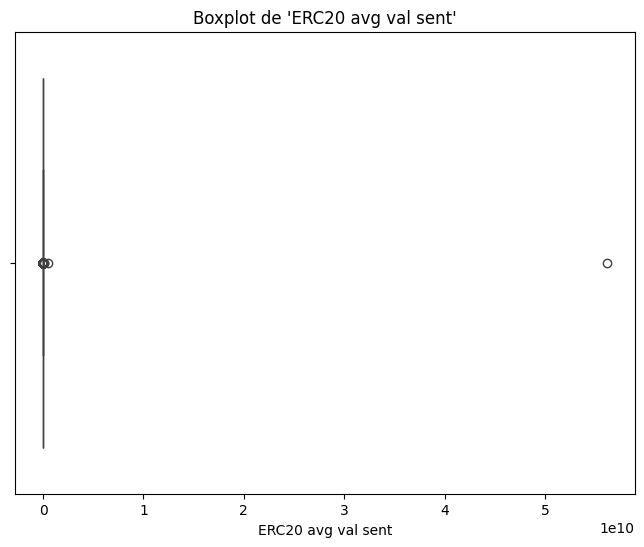

In [35]:
# Boxplot para identificar outliers em 'ERC20 avg val sent'
plt.figure(figsize=(8, 6))
sns.boxplot(x=df["ERC20 avg val sent"])
plt.xlabel("ERC20 avg val sent")
plt.title("Boxplot de 'ERC20 avg val sent'")
plt.show()


## **BASELINE**

In [36]:
# Calcular média e desvio padrão para 'Sent tnx'
mean_sent = df['Sent tnx'].mean()
std_sent = df['Sent tnx'].std()

threshold = mean_sent + 3 * std_sent
print(threshold, mean_sent, std_sent)

2387.6107960620707 115.93171425668123 757.2263606017965


In [37]:
# Marcar como anomalia as transações com 'Sent tnx' acima do threshold
df['baseline_anomaly'] = df ['Sent tnx'].apply(lambda x:1 if x > threshold else 0)

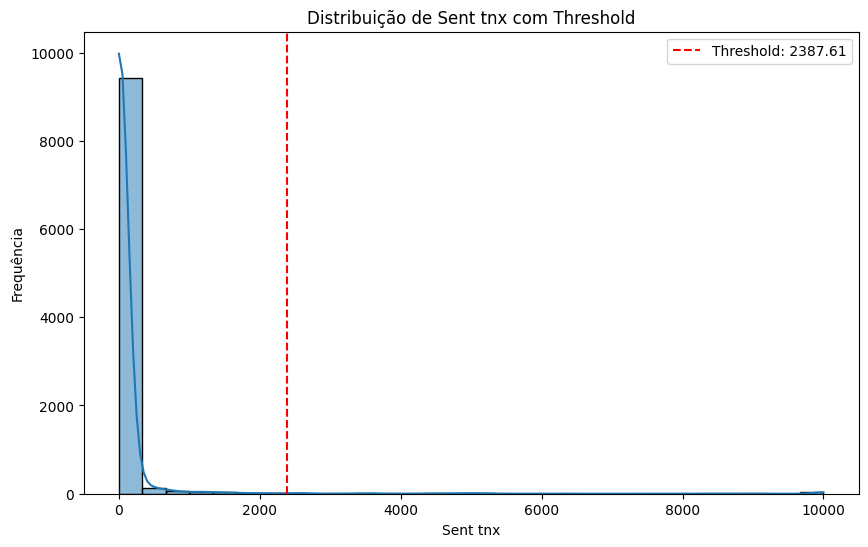

In [38]:
# Exibir histograma com o threshold
# Exibir histograma com o threshold
plt.figure(figsize=(10, 6))
sns.histplot(df["Sent tnx"], bins=30, kde=True)

plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.2f}')
plt.xlabel('Sent tnx')
plt.ylabel('Frequência')
plt.title('Distribuição de Sent tnx com Threshold')
plt.legend()
plt.show()



In [39]:
print("Número de anomalias (baseline):", df['baseline_anomaly'].sum())


Número de anomalias (baseline): 116


In [40]:
# Método Baseline:
print(classification_report(df['is_fraud'], df['baseline_anomaly']))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9697
           1       1.00      0.81      0.89       144

    accuracy                           1.00      9841
   macro avg       1.00      0.90      0.95      9841
weighted avg       1.00      1.00      1.00      9841



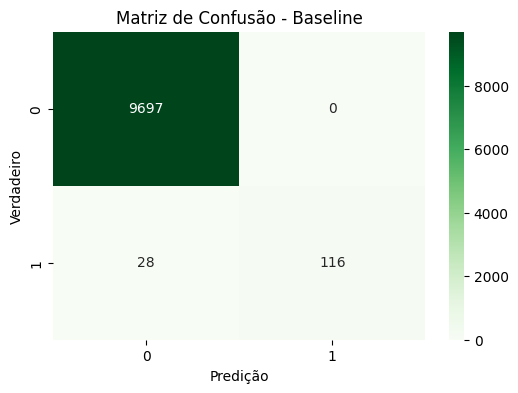

In [41]:
# plotar matriz de confusão
cm_baseline = confusion_matrix(df['is_fraud'], df['baseline_anomaly'])
plt.figure(figsize=(6, 4))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Greens')
plt.title('Matriz de Confusão - Baseline')
plt.xlabel('Predição')
plt.ylabel('Verdadeiro')
plt.show()

## **AULA 2 :)**

In [43]:
# Define as features utilizadas para os modelos
features = ["Sent tnx", "Received Tnx", "Avg min between sent tnx", "Time Diff between first and last (Mins)", "ERC20 avg val sent"]

print("Contagem de NANs nas features: ")
print(df[features].isna().sum())

df_ml = df.dropna(subset=features).copy()

# 'is_fraud' not in df_ml.columns:
df_ml["is_fraud"] = df["is_fraud"]

Contagem de NANs nas features: 
Sent tnx                                     0
Received Tnx                                 0
Avg min between sent tnx                     0
Time Diff between first and last (Mins)      0
ERC20 avg val sent                         829
dtype: int64


Número de anomalias identificadas pelo Isolation Forest 451


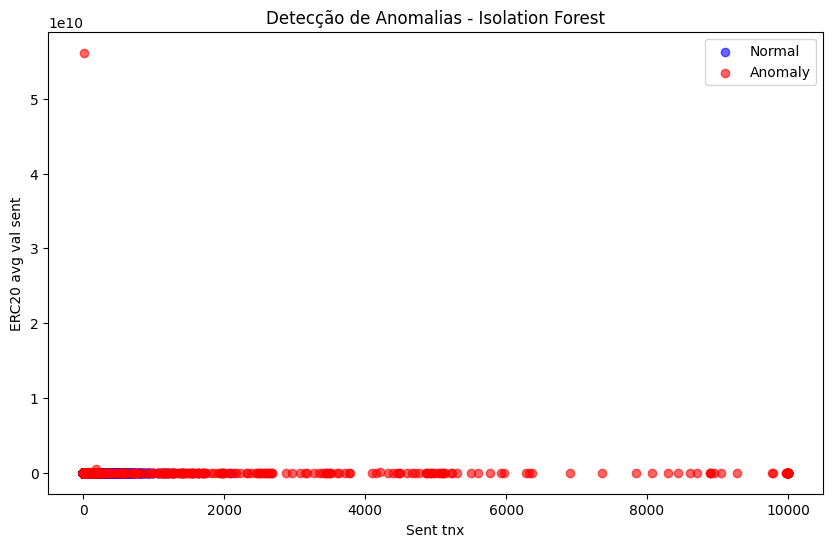

In [46]:
# Criação e treinamento do modelo Isolation Forest
from sklearn.ensemble import IsolationForest

if_model = IsolationForest(contamination=0.05, random_state=42)
df_ml['if_anomaly'] = if_model.fit_predict(df_ml[features])
df_ml['if_anomaly_flag'] = df_ml['if_anomaly'].apply(lambda x: 1 if x == -1 else 0)
print('Número de anomalias identificadas pelo Isolation Forest', df_ml['if_anomaly_flag'].sum())

# Visualização: Scatter plot comparando duas features com as anomalias
plt.figure(figsize=(10, 6))
normal = df_ml[df_ml['if_anomaly_flag'] == 0]
anomaly = df_ml[df_ml['if_anomaly_flag'] == 1]
plt.scatter(normal['Sent tnx'], normal['ERC20 avg val sent'], c="blue", label="Normal", alpha=0.6)
plt.scatter(anomaly['Sent tnx'], anomaly['ERC20 avg val sent'], c="red", label="Anomaly", alpha=0.6)
plt.xlabel('Sent tnx')
plt.ylabel('ERC20 avg val sent')
plt.title('Detecção de Anomalias - Isolation Forest')
plt.legend()
plt.show()

In [47]:
# CLASSIFICATION REPORT
print("Classification Report - Isolation Forest:")
print(classification_report(df_ml['is_fraud'], df_ml['if_anomaly_flag']))

Classification Report - Isolation Forest:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      8868
           1       0.31      0.97      0.47       144

    accuracy                           0.97      9012
   macro avg       0.65      0.97      0.73      9012
weighted avg       0.99      0.97      0.97      9012



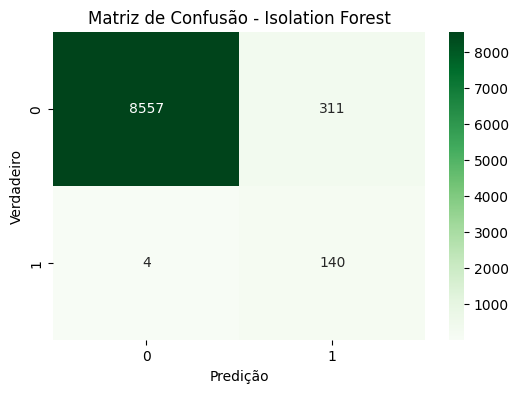

In [49]:
# Calcula a matriz de confusão entre os rótulos reais ('is_fraud')
cm_if = confusion_matrix(df_ml['is_fraud'], df_ml['if_anomaly_flag'])
plt.figure(figsize=(6, 4))
sns.heatmap(cm_if, annot=True, fmt="d", cmap="Greens")
plt.title("Matriz de Confusão - Isolation Forest")
plt.xlabel("Predição")
plt.ylabel("Verdadeiro")
plt.show()

Número de anomalias identificadas pelo DBSCAN: 6246


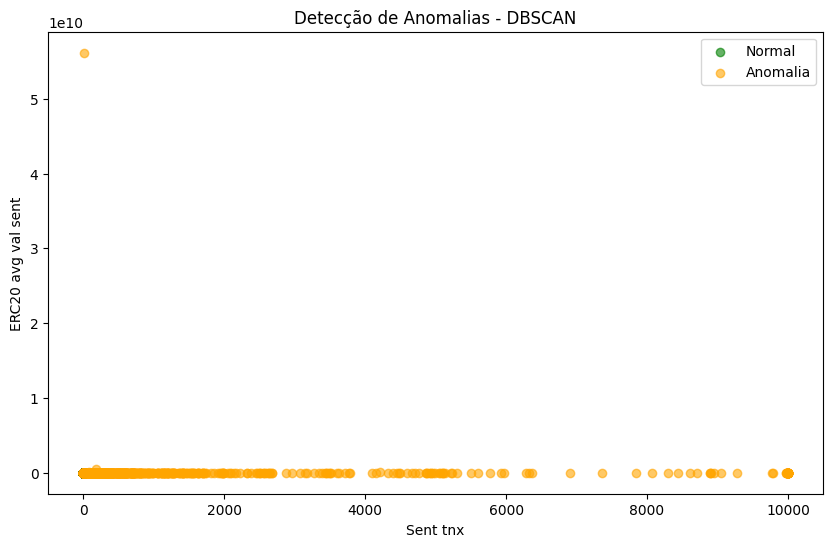

In [51]:
# DBSCAN
from sklearn.cluster import DBSCAN

dbscan_model = DBSCAN(eps=3, min_samples=5)
df_ml['dbscan_labels'] = dbscan_model.fit_predict(df_ml[features])
df_ml['dbscan_anomaly'] = df_ml['dbscan_labels'].apply(lambda x: 1 if x == -1 else 0)
print("Número de anomalias identificadas pelo DBSCAN:", df_ml['dbscan_anomaly'].sum())

# Visualização: Scatter plot
plt.figure(figsize=(10, 6))
normal_db = df_ml[df_ml['dbscan_anomaly'] == 0]
anomaly_db = df_ml[df_ml['dbscan_anomaly'] == 1]
plt.scatter(normal_db['Sent tnx'], normal_db['ERC20 avg val sent'], c="green", label="Normal", alpha=0.6)
plt.scatter(anomaly_db['Sent tnx'], anomaly_db['ERC20 avg val sent'], c="orange", label="Anomalia", alpha=0.6)
plt.xlabel('Sent tnx')
plt.ylabel('ERC20 avg val sent')
plt.title('Detecção de Anomalias - DBSCAN')
plt.legend()
plt.show()

In [52]:
# CLASSIFICATION REPORT
print("Classification Report - DBSCAN:")
print(classification_report(df_ml['is_fraud'], df_ml['dbscan_anomaly']))

Classification Report - DBSCAN:
              precision    recall  f1-score   support

           0       1.00      0.31      0.48      8868
           1       0.02      1.00      0.05       144

    accuracy                           0.32      9012
   macro avg       0.51      0.66      0.26      9012
weighted avg       0.98      0.32      0.47      9012



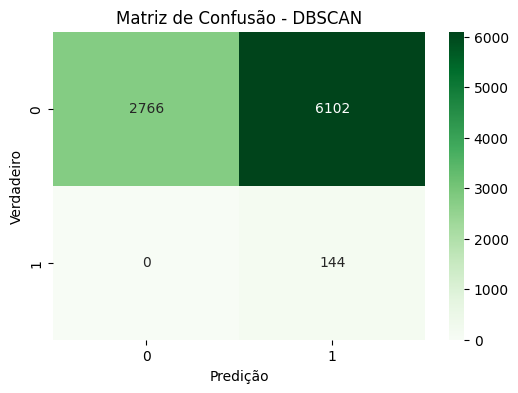

In [53]:
# Avaliação do DBSCAN com Matriz de Confusão
cm_db = confusion_matrix(df_ml['is_fraud'], df_ml['dbscan_anomaly'])
plt.figure(figsize=(6, 4))
sns.heatmap(cm_db, annot=True, fmt="d", cmap="Greens")
plt.title("Matriz de Confusão - DBSCAN")
plt.xlabel("Predição")
plt.ylabel("Verdadeiro")
plt.show()

In [54]:
# Comparar o número de anomalias detectadas por cada método
methods = {
    "Baseline (Threshold)": df_ml['baseline_anomaly'].sum(),
    "Isolation Forest": df_ml['if_anomaly_flag'].sum(),
    "DBSCAN": df_ml['dbscan_anomaly'].sum(),
}

comparative_df = pd.DataFrame(list(methods.items()), columns=['Método', 'Número de Anomalias'])
print(comparative_df)

                 Método  Número de Anomalias
0  Baseline (Threshold)                  116
1      Isolation Forest                  451
2                DBSCAN                 6246
